# Computing lag plots 

In this notebook we show how we can use Pandas to compute lag plots and how we can interpret them on some examples.

We will work with a monthly retail sales dataset (found [here](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv)).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 1, in the folder "01-Datasets" from this repo.

## Data Set Synopsis

The timeseries is collected between January 1992 and May 2016.

It consists of a single series of monthly values representing sales volumes. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context("talk")

# Lag plots

A lag plot is simply a scatter plot where we plot $y_t$ against a lagged version of itself $y_{t-k}$. A helpful function in Pandas, `pd.plotting.lag_plot`, allows us to do this from a given series. However, this method plots $y_{t+k}$ against $y_t$ which gives the same result as plotting $y_t$ against $y_{t-k}$.

## White noise

Let's create a toy dataset of white noise which was explained in lectures.

In [2]:
num_timesteps = 300  # Length of time series we want.
np.random.seed(0)  # Ensures we generate the same random numbers every time.

y = np.random.normal(loc=0, scale=1, size=num_timesteps)
ts = pd.date_range(start="2000-01-01", periods=num_timesteps, freq="D")

df = pd.DataFrame(data={"y": y}, index=ts)
df.head()

,y
2000-01-01,1.764052
2000-01-02,0.400157
2000-01-03,0.978738
2000-01-04,2.240893
2000-01-05,1.867558


Plot the time series.


Text(0.5, 0, 'Time')

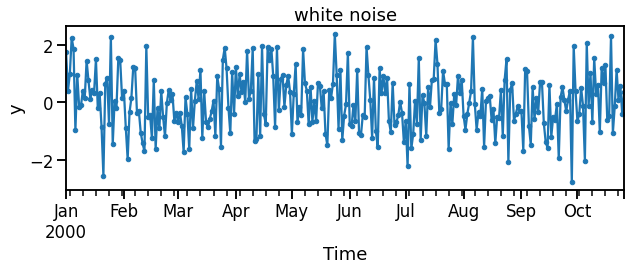

In [3]:
ax = df.plot(figsize=[10, 3], legend=None, marker=".")
ax.set_title("white noise")
ax.set_ylabel("y")
ax.set_xlabel("Time")

Let's plot the lag plot.

Text(0.5, 1.0, 'Lag plot with lag 1')

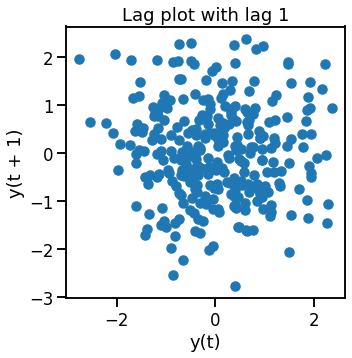

In [4]:
fig, ax = plt.subplots(figsize=[5, 5])
ax = pd.plotting.lag_plot(df["y"], lag=1, ax=ax)
ax.set_title("Lag plot with lag 1")

Let's plot many lag plots with different lags.

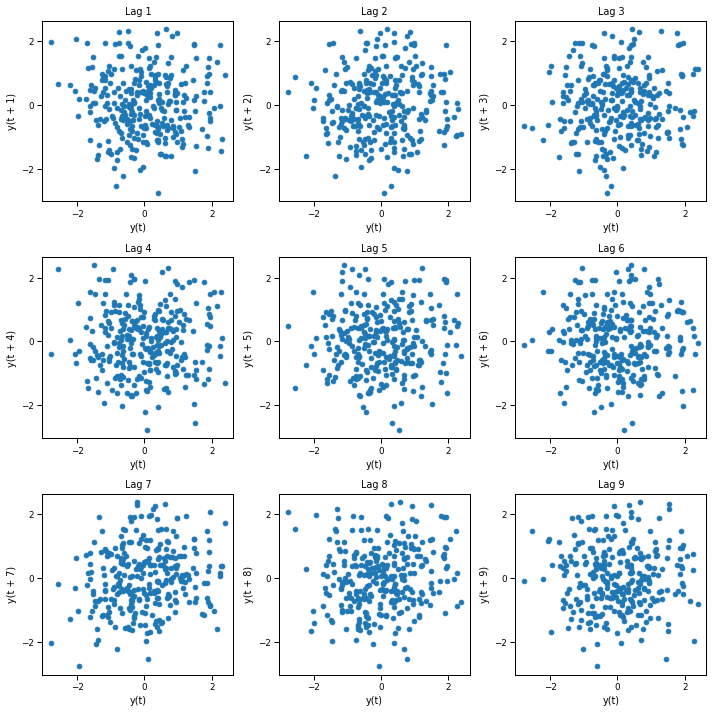

In [5]:
with sns.plotting_context("paper"): # Sets the plotting format for these specific plots.
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[10, 10])
    for i, ax_ in enumerate(ax.flatten()):
        pd.plotting.lag_plot(df["y"], lag=i + 1, ax=ax_)
        ax_.set_title(f"Lag {i+1}")
        ax_.ticklabel_format(style="sci", scilimits=(0, 0))
    plt.tight_layout()

We see a bunch of blobs with no particular structure. This suggests that none of the lags shown above will be helpful for forecasting.

## Trend and seasonality: Retail sales example

Now let's load the data from a real world example.

In [6]:
# Load retail sales dataset
df = pd.read_csv(
    "../Datasets/example_retail_sales.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

Text(0.5, 0, 'Time')

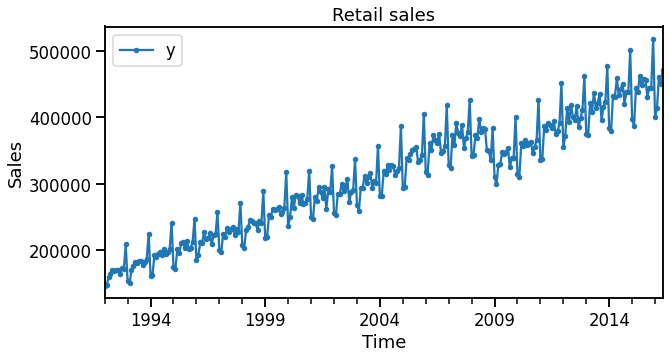

In [7]:
# Plot the time series
ax = df.plot(y="y", marker=".", figsize=[10, 5])
ax.set_title('Retail sales')
ax.set_ylabel('Sales')
ax.set_xlabel('Time')

Let's plot many lag plots with different lags.

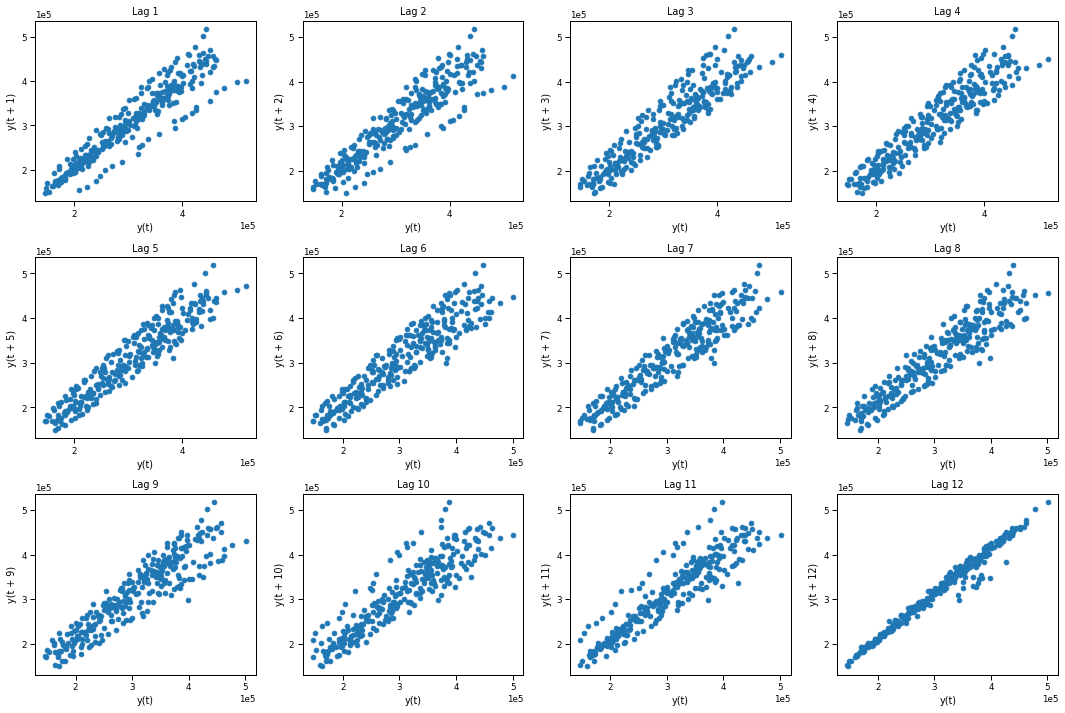

In [8]:
with sns.plotting_context("paper"):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=[15, 10])
    for i, ax_ in enumerate(ax.flatten()):
        pd.plotting.lag_plot(df["y"], lag=i + 1, ax=ax_)
        ax_.set_title(f"Lag {i+1}")
        ax_.ticklabel_format(style="sci", scilimits=(0, 0))
    plt.tight_layout()

Due to the strong trend component in the time series we see that the sales time series is strongly correlated with itself at many different lags. The yearly seasonality is seen in the very strong correlation seen in the Lag 12 plot. As we would expect, this suggests a lag of 12 would be a useful feature.

Text(0.5, 0, 'Time')

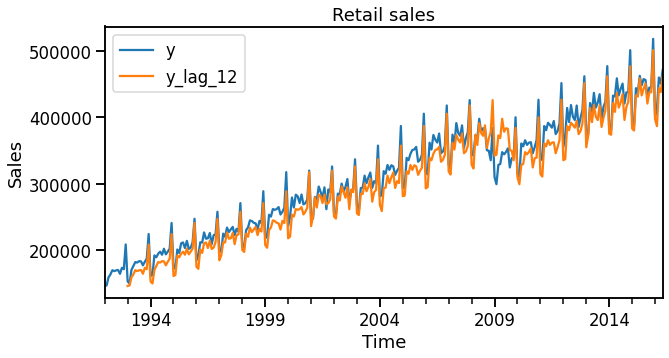

In [9]:
# Compute the lag
df["y_lag_12"] = df["y"].shift(periods=12)

# Plot the sales and the lag 100 sales
ax = df.plot(y=["y", "y_lag_12"], figsize=[10, 5])

ax.set_title('Retail sales')
ax.set_ylabel('Sales')
ax.set_xlabel('Time')

We expect the correlation to be greater with a shorter lag (more recent in time) than a larger lag (more distant in time). We check this below by comparing the lag plot for `lag=1` month and `lag=100` months.

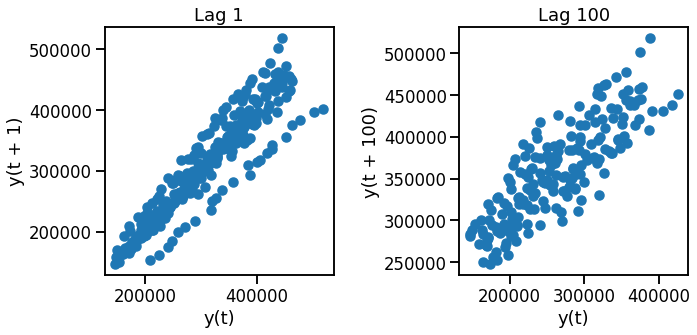

In [10]:
# Plot lag=1 vs lag=100
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[10, 5])
pd.plotting.lag_plot(df["y"], lag=1, ax=ax[0])
ax[0].set_title(f"Lag 1")
pd.plotting.lag_plot(df["y"], lag=100, ax=ax[1])
ax[1].set_title(f"Lag 100")

plt.tight_layout()

We can see that the scatter plot is more spread out for a lag of 100 compared to a lag of 1 as expected. But we still see a strong correlation. Why is this? It is due to the strong trend component. This can be more clearly understood by plotting the original timeseries and lagged timeseries together. 

<AxesSubplot:xlabel='ds'>

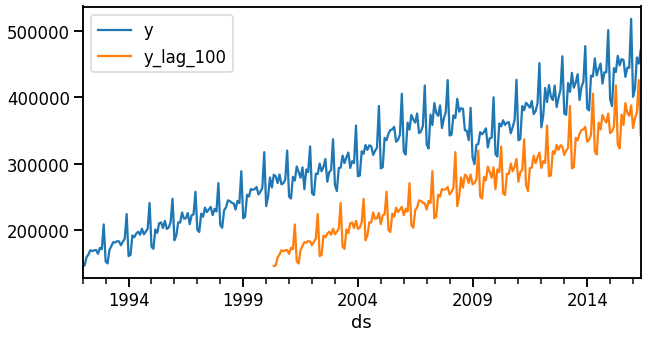

In [11]:
# Compute the lag
df["y_lag_100"] = df["y"].shift(periods=100)

# Plot the sales and the lag 100 sales
df.plot(y=["y", "y_lag_100"], figsize=[10, 5])

Visually it is clear that these two timeseries are highly correlated. When one has low magnitude so does the other, when one has a high magnitude so does the other. This is why even at large lags we see high autocorrelation in the presence of a strong trend. 

So now we have shown how we can examine lag plots to sense check and select useful lags. We also have shown that just because the autocorrelation is high for large lags does not mean we should use large lags as features. By examining the autocorrelation and partial autocorrelation function in the next notebooks we shall see that a lower order lags will contribute the most information. Also using our own understanding of the domain we can rule out that the exact sales 100 months in the past should not have much of an effect on the sales in the present.